# Import useful functions

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
import pandas as pd
from astropy.table import Table
import scipy

# Background equations

In [2]:
#------ BACKGROUND EQUATIONS ------

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_L = Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 4 + Omega_lambda
    
    if alpha_tilde == 0:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2)
    
    # small alpha approximation to deal with numerical instabilities
    elif alpha_tilde < 1e-10 and E_L < 1e4:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2 - alpha_tilde* (E_L**2)/4)
    
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans


# Equations to test theory

In [3]:
# --- BAO ----

# ------ equations for BAO ------ c = 1

# Angular diameter distance
def D_M_H0(z,cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)

    D = np.zeros(len(z))
    for i in range(len(z)):
        chi = scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z[i])[0]
        if Omega_k > 0:
            D[i] = np.sinh(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        elif Omega_k < 0:
            D[i] = np.sin(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        else:
            D[i] = chi
    return D

# Hubble distance
def D_H_H0(z,cosmo):
    D = np.zeros(len(z))
    for i in range(len(z)):
        D[i] = 1/E(z[i],cosmo)
    return D

# Spherically-averaged distance (historical BAO distance)
def D_V_H0(z,cosmo):
    return (z*D_H_H0(z,cosmo)*D_M_H0(z,cosmo)**2)**(1/3)

# Used to find z_CMB
def g1(wb):
    return (0.0783*wb**(-0.238))/(1 + 39.5*wb**(0.763))

# Used to find z_CMB
def g2(wb):
    return 0.56/(1 + 21.1*wb**(1.81))

# redshift at which the BB occurs -- note that for wb approx 0 z_CMB = z_d (drag epoch)
def z_CMB(Omg_b,Omg_m,h):
    wb = Omg_b * h**2
    wm = Omg_m * h**2
    return 1048*(1+0.00124*wb**(-0.738))*\
           (1 + g1(wb)*wm**g2(wb))

# Used to find r_s - only works for 0.0025 < wb < 0.25 and 0.025 < wm < 0.64 
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

# Note that we assumed sound horizon was zero at the end of nucleosynthesis
def r_d_H0(cosmo,h):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omega_b*h**2)*x))), 2.5e-9, 1/(1+z_CMB(Omega_b,Omega_m,h)))[0]

In [4]:
# ---- SNe ----

# --- Equations for mu ----

def D_L(z,cosmo,H0):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)

    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    c = 3e5
    D = np.zeros(len(z))
    for i in range(len(z)):
        chi = scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z[i])[0]
        if Omega_k > 0:
            D[i] = (c*(1+z[i])/H0)*np.sinh(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        elif Omega_k < 0:
            D[i] = (c*(1+z[i])/H0)*np.sin(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        else:
            D[i] = (c*(1+z[i])/H0)*chi
    return D

# dl has units of Mpc
def mu(dl):
    return 5*np.log10(dl/1e-5)

# Data

In [5]:
#import data for SNe

# get the data

# data values for z_b, mu_b
tab_vals = Table.read(r'~/Desktop/Newcastle/4DEGB/Data/SneTable.tex')

# covariance matrix for our data - NOTE MISS FACTOR OF 10^-6
tab_cov = Table.read(r'/home/c2042999/Desktop/Newcastle/4DEGB/Data/SneTable_covmat.tex')

# get it in matrix form
tab_cov = np.lib.recfunctions.structured_to_unstructured(tab_cov.as_array())
tab_cov = tab_cov.filled(0)
# get the correct symmetric format
tab_cov = 1e-6 * (np.rot90(np.fliplr(tab_cov)) + tab_cov - np.diag(np.diag(tab_cov)))

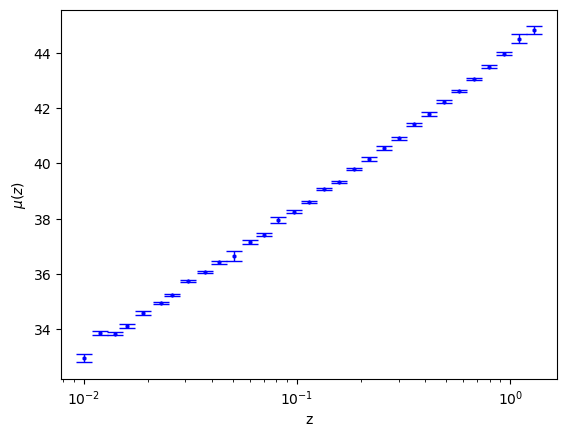

In [6]:
# Plot data SNe

x_SNe = np.array(tab_vals["$z_b$"])
cov_SNe = tab_cov
y_SNe = np.array(tab_vals["$\mu_b$"])

plt.errorbar(x_SNe, y_SNe, yerr=np.array(np.sqrt(np.diag(cov_SNe))),ls = "none", linewidth=1, capsize=6, color = "b")
plt.scatter(x_SNe, y_SNe, s = 5, marker = "h", color = "b")

plt.xlabel("z")
plt.ylabel(r"$\mu(z)$");
plt.xscale("log")

In [7]:
# Get data BAO

# BOSS Galaxy, eBOSS LRG, eBOSS Quasar =, Ly\alpha-Ly\alpha and Ly\alpha-Quasar data
x_D_mh_over_rd = np.array([0.38,0.51,0.70,1.48,2.33,2.33])

y_D_m_over_rd = np.array([10.23,13.36,17.86,30.69,37.6,37.3])
yerr_D_m_over_rd =np.diag([0.17,0.21,0.33,0.8,1.9,1.7])

y_D_h_over_rd = np.array([25,22.33,19.33,13.26,8.93,9.08])
yerr_D_h_over_rd =np.diag([0.76,0.58,0.53,0.55,0.28,0.34])

# eBOSS ELG data
x_ELG = 0.85
y_ELG_Dv_over_rd = 18.33
yerr_ELG_Dv_over_rd = 0.62 # TODO how do you account for different max/min?

# 6dFGS and MGS data
x_6dFGS = 0.106
y_6dFGS_Dv_over_rd = 1/0.336
yerr_6dFGS_Dv_over_rd = 0.015/0.336**2

rd_fid = 148.69
x_MGS = 0.15
y_MGS_Dv_over_rd = 664 / rd_fid
yerr_MGS_Dv_over_rd = 25 / rd_fid # TODO check

# Combine data
x_BAO = [np.array([x_ELG,x_6dFGS,x_MGS]),x_D_mh_over_rd,x_D_mh_over_rd]
y_BAO = [np.array([y_ELG_Dv_over_rd,y_6dFGS_Dv_over_rd,y_MGS_Dv_over_rd]),y_D_m_over_rd,y_D_h_over_rd]
cov_BAO = [np.diag([yerr_ELG_Dv_over_rd**2,yerr_6dFGS_Dv_over_rd**2,yerr_MGS_Dv_over_rd**2]) , yerr_D_m_over_rd**2 , yerr_D_h_over_rd**2]

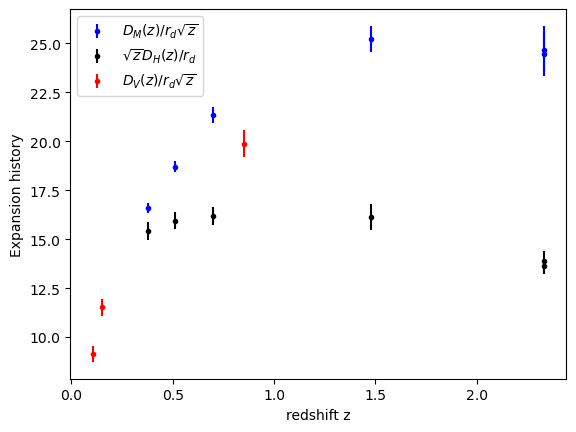

In [8]:
# Plot data BAO

plt.errorbar(x_D_mh_over_rd, y_D_m_over_rd/np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_m_over_rd/np.sqrt(x_D_mh_over_rd)), fmt=".b", capsize=0, label = r"$D_M(z)/r_d\sqrt{z}$")
plt.errorbar(x_D_mh_over_rd, y_D_h_over_rd*np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_h_over_rd)*np.sqrt(x_D_mh_over_rd), fmt=".k", capsize=0, label = r"$\sqrt{z}D_H(z)/r_d$")

plt.errorbar([x_6dFGS,x_MGS,x_ELG], [y_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), y_MGS_Dv_over_rd/np.sqrt(x_MGS), y_ELG_Dv_over_rd/np.sqrt(x_ELG)],\
             yerr=[yerr_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), yerr_MGS_Dv_over_rd/np.sqrt(x_MGS), yerr_ELG_Dv_over_rd/np.sqrt(x_ELG)], fmt=".r", capsize=0, label = r"$D_V(z)/r_d\sqrt{z}$")
plt.legend()
x0 = np.linspace(0, 10, 500)
plt.xlabel("redshift z")
plt.ylabel("Expansion history");

In [9]:
# Combined data

x = [x_SNe,x_BAO]
y = [y_SNe, y_BAO]
cov = [cov_SNe,cov_BAO]

# Likelihood for BAO, "BAO"

In [10]:
def log_likelihood_DV(theta, z, y, yerr):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    
    Omg_c, Omg_b, h = theta
    alpha_t = 0
    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    cosmo = [Omg_c , Omg_b , 0 , Omg_r , alpha_t,0]
    model = D_V_H0(z,cosmo)/r_d_H0(cosmo,h)
    
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(yerr)),np.transpose(y-model))

In [11]:
def log_likelihood_DM(theta, z, y, yerr):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    
    Omg_c, Omg_b, h = theta
    alpha_t = 0
    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    cosmo = [Omg_c, Omg_b , 0 , Omg_r , alpha_t,0]
    
    model = D_M_H0(z,cosmo)/r_d_H0(cosmo,h)
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(yerr)),np.transpose(y-model))

In [12]:
def log_likelihood_DH(theta, z, y, yerr):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    
    Omg_c, Omg_b, h = theta
    alpha_t = 0
    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    cosmo = [Omg_c, Omg_b , 0 , Omg_r , alpha_t,0]
    
    model = D_H_H0(z,cosmo)/r_d_H0(cosmo,h)
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(yerr)),np.transpose(y-model))

In [13]:
def log_likelihood_BAO(theta, x, y, cov):
    x_v, x_m, x_h = x
    y_v, y_m, y_h = y
    yerr_v, yerr_m, yerr_h = cov
    return log_likelihood_DV(theta, x_v, y_v, yerr_v) + log_likelihood_DM(theta, x_m, y_m, yerr_m)\
            + log_likelihood_DH(theta, x_h, y_h, yerr_h)

# Likelihood for SNe data "SNe"

In [14]:
def log_likelihood_SNe(theta, z, y, cov):
    Omg_c, Omg_b, h = theta
    alpha_t = 0
    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    cosmo = [Omg_c , Omg_b , 0 , Omg_r , alpha_t,0]
    
    model = np.array(mu(D_L(z, cosmo, 100*h)))
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(cov)),np.transpose(y-model))

# Combined MCMC analysis

In [15]:
def log_prior(theta):
    Omg_c, Omg_b, h = theta
    wb = Omg_b*h**2
    wm = (Omg_c + Omg_b)*h**2
    if 0.025 < wm < 0.64 and 0.0025 < wb < 0.25 and 0 < Omg_c < 1 and 0 < h < 1:
        return 0.0
    return -np.inf

In [16]:
def log_probability(theta, x, y, cov):
    lp = log_prior(theta)
    x_SNe , x_BAO = x
    y_SNe , y_BAO = y
    cov_SNe , cov_BAO = cov
    if not np.isfinite(lp):
        return -np.inf
    log_prob = lp + log_likelihood_BAO(theta, x_BAO, y_BAO, cov_BAO) \
             + log_likelihood_SNe(theta, x_SNe, y_SNe, cov_SNe)
    return log_prob

In [17]:
#MCMC method

# Choose the estimated parameters.
Omg_c_est = 0.6
Omg_b_est = 0.02
h_est = 0.5

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [Omg_c_est , Omg_b_est, h_est] + 1e-2 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, cov)
)
sampler.run_mcmc(pos, 1000, progress=True);

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


(1650, 3)


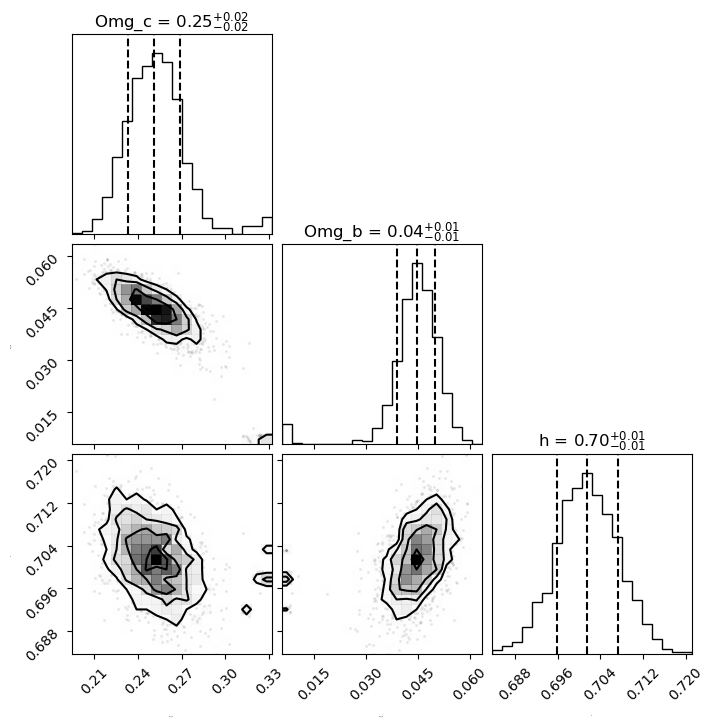

In [18]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
labels = ["Omg_c", "Omg_b", "h", "alpha_t"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, show_titles=True, quantiles=[0.16, 0.50, 0.84],
                    label_kwargs={'labelpad':20, 'fontsize':0}, fontsize=8
);


50
1000
3
1000


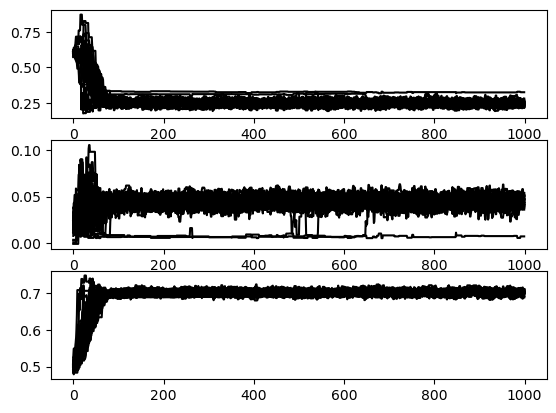

In [19]:
samples_chain = sampler.chain
print(len(samples_chain))
print(len(samples_chain[0]))
print(len(samples_chain[0][0]))
print(len(samples_chain[0, :, 0]))

fig, ax = plt.subplots(3)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")
    ax[2].plot(samples_chain[i, :, 2], color = "black")


In [20]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.15f}_{{-{1:.15f}}}^{{{2:.15f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

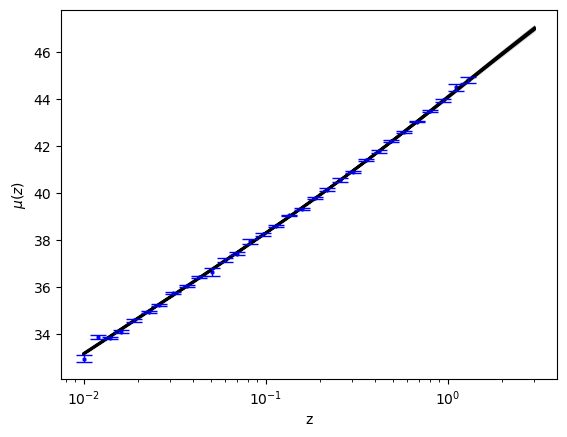

In [21]:
# --- SNe: PLOT DATA WITH ESTIMATED PARAMS -----

# cosmic chronometers
xl = np.linspace(0.01,3,int(1e2))
for Omg_c,Omg_b, h in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    alpha_t = 0
    H0 = 100*h
    Omg_r = (2.47e-5*h**-2)*1.6949484 
    mu_val = mu(D_L(xl, [Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0], H0))
    plt.plot(xl, np.array(mu_val), color="k", alpha=0.1)
    
plt.errorbar(x_SNe, y_SNe, yerr=np.array(np.sqrt(np.diag(cov_SNe))),ls = "none", linewidth=1, capsize=6, color = "b")
plt.scatter(x_SNe, y_SNe, s = 5, marker = "h", color = "b")

plt.xlabel("z")
plt.ylabel(r"$\mu(z)$");
plt.xscale("log")

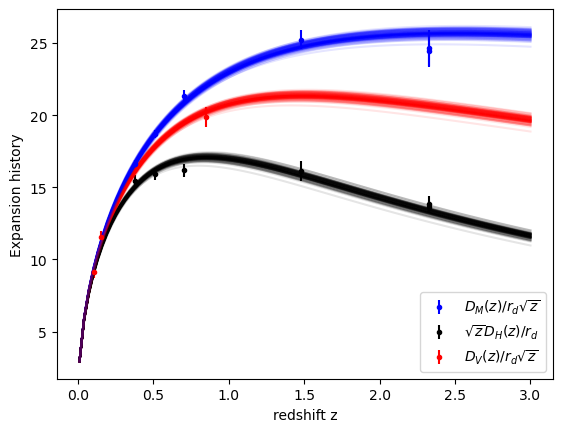

In [22]:
# --- BAO: PLOT DATA WITH ESTIMATED PARAMS -----

# data
plt.errorbar(x_D_mh_over_rd, y_D_m_over_rd/np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_m_over_rd/np.sqrt(x_D_mh_over_rd)), fmt=".b", capsize=0, label = r"$D_M(z)/r_d\sqrt{z}$")
plt.errorbar(x_D_mh_over_rd, y_D_h_over_rd*np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_h_over_rd)*np.sqrt(x_D_mh_over_rd), fmt=".k", capsize=0, label = r"$\sqrt{z}D_H(z)/r_d$")

plt.errorbar([x_6dFGS,x_MGS,x_ELG], [y_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), y_MGS_Dv_over_rd/np.sqrt(x_MGS), y_ELG_Dv_over_rd/np.sqrt(x_ELG)],\
             yerr=[yerr_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), yerr_MGS_Dv_over_rd/np.sqrt(x_MGS), yerr_ELG_Dv_over_rd/np.sqrt(x_ELG)], fmt=".r", capsize=0, label = r"$D_V(z)/r_d\sqrt{z}$")
plt.legend()
plt.xlabel("redshift z")
plt.ylabel("Expansion history");


xl = np.linspace(0.01,3,int(1e2))
for Omg_c, Omg_b,h in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    alpha_t = 0
    Omg_r = (2.47e-5*h**-2)*1.6949484 
    plt.plot(xl, np.sqrt(xl)*D_H_H0(xl,[Omg_c , Omg_b , 0 , Omg_r , alpha_t , 0])/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t , 0],h), color="k", alpha=0.1)
    plt.plot(xl, D_V_H0(xl,[Omg_c , Omg_b , 0 , Omg_r , alpha_t , 0])/(r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t , 0],h)*np.sqrt(xl)), color="r", alpha=0.1)
    plt.plot(xl, D_M_H0(xl,[Omg_c , Omg_b , 0 , Omg_r , alpha_t , 0])/(r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t , 0],h)*np.sqrt(xl)), color="b", alpha=0.1)
